In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, BatchNorm
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [54]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim, *els_ = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
            model.append(
                BatchNorm(axis=(0,))
            )
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory_old(Xt, b_f, b_b, dt, theta, forwards):
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
    
    @staticmethod
    @partial(jit, static_argnums=(1,2, 5))
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards):
        if not forwards : Xt = Xt[: , ::-1, :]
        def inner_t_loss(x):
            
            b_minus  = b_b(theta, x)
            b_plus = b_f(theta, x)

            delta_Xt = x[:-1, :]  - x[ 1:, :]

            sign = 1.0 if forwards else -1.0

            ito_integral = sign *  (b_plus[1:,:] - b_minus[:-1,:])  * delta_Xt

            time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here

            return ito_integral.sum() - 0.5 * time_integral.sum()
        out = jax.vmap(inner_t_loss)(Xt)
        return out
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)
    

    @staticmethod
#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        t, Xt = cIPFP.sample_trajectory(batch, dt, theta,  sigma, b, N, sde_solver, forwards)
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = cIPFP.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
#     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        for i in tqdm(range(IPFP_iterations)):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
         

        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

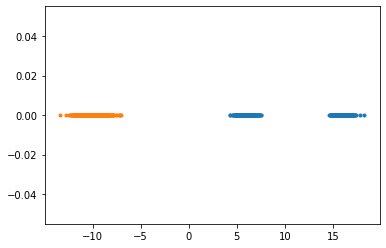

In [55]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 10
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 16
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 6
X2 = np.concatenate((X21, X22), axis=0)

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [56]:

c = cIPFP(X1, X2,  number_time_steps=100, batch_size=150 , step_size = 0.0001, weights=[50,50,50,50])

In [57]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [58]:
theta_f[0][1].shape, theta_f[1]

((50,),
 (DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0.], dtype=float32),
  DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1.], dtype=float32)))

In [59]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

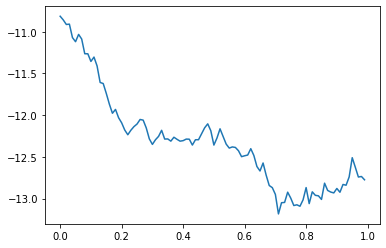

In [60]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [61]:
t, Xts = c.sample_trajectory(X1,c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver)

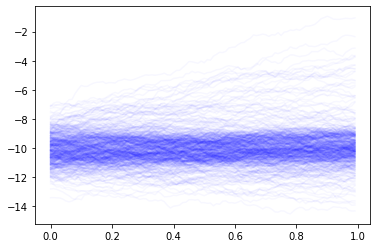

In [62]:
for i in range(n):
    plt.plot(t, Xts[i,:,:], 'b', alpha=0.03, )

In [63]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [64]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [65]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [66]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 949 ms, sys: 12.3 ms, total: 961 ms
Wall time: 920 ms


DeviceArray(90.194786, dtype=float32)

In [67]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 18.6 ms, sys: 36 µs, total: 18.6 ms
Wall time: 14.4 ms


DeviceArray(92.66151, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [38]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 20.7 s, sys: 41.5 ms, total: 20.8 s
Wall time: 20.8 s


In [39]:
%%time
kek = gradient(theta_f, X1, True)

CPU times: user 0 ns, sys: 1e+03 µs, total: 1e+03 µs
Wall time: 843 µs


loss b 3256.99755859375
loss f 88.09815979003906



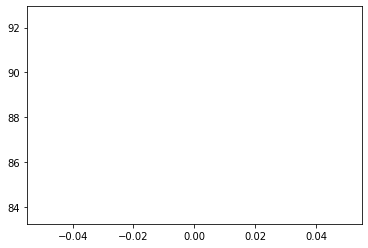

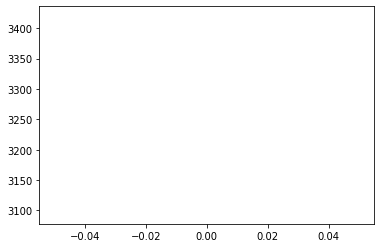

CPU times: user 3min 6s, sys: 727 ms, total: 3min 7s
Wall time: 3min 6s


In [68]:
%%time
c.fit(1,1)

loss b 3820.56640625
loss f 90.35346984863281



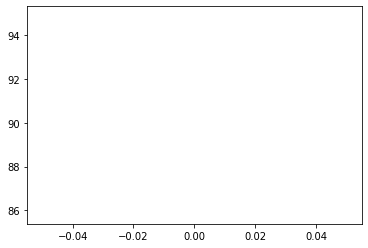

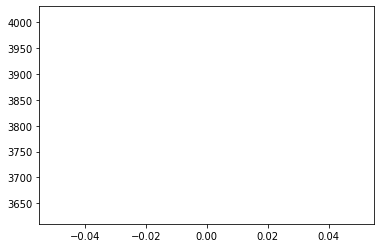

CPU times: user 2.89 s, sys: 497 ms, total: 3.38 s
Wall time: 2.62 s


In [69]:
%%time
c.fit(1,1)

loss b 3679.846435546875
loss b 3405.051513671875
loss b 3623.43603515625
loss b 4182.09228515625
loss b 3274.93603515625
loss b 3451.041259765625
loss b 3557.030517578125
loss b 3829.33349609375
loss b 3994.253173828125
loss b 3394.009521484375
loss b 3820.5458984375
loss b 3780.326904296875
loss b 3305.55078125
loss b 3250.145263671875
loss b 3745.19482421875
loss b 3389.330322265625
loss b 3477.967529296875
loss b 3499.032470703125
loss b 3830.34765625
loss b 3766.4384765625
loss b 3277.518798828125
loss b 3172.20361328125
loss b 2974.229248046875
loss b 3701.011962890625
loss b 3085.697509765625
loss b 3782.935302734375
loss b 3436.412353515625
loss b 3531.09521484375
loss b 3603.472900390625
loss b 3209.2373046875
loss f 90.4869155883789
loss f 88.02665710449219
loss f 86.84043884277344
loss f 87.46402740478516
loss f 85.88301086425781
loss f 88.79083251953125
loss f 86.51866912841797
loss f 82.54911804199219
loss f 82.92035675048828
loss f 82.08560180664062
loss f 82.564033508300

loss f 64.06941986083984
loss f 65.02680206298828
loss f 61.87837600708008
loss f 65.67596435546875
loss f 62.334190368652344
loss f 65.77871704101562
loss f 65.25129699707031
loss f 67.68858337402344
loss f 62.31528854370117
loss f 61.61928176879883
loss f 60.19430923461914
loss f 60.50037384033203
loss f 66.24720001220703
loss f 65.63191223144531
loss f 65.38707733154297
loss f 63.015926361083984
loss f 61.256771087646484
loss f 61.44660186767578
loss f 67.11289978027344
loss f 61.94350051879883
loss f 61.28657150268555
loss f 61.78934860229492
loss f 61.911705017089844
loss f 64.36258697509766
loss f 63.16813278198242
loss b 3309.82861328125
loss b 2892.886962890625
loss b 2536.1455078125
loss b 2857.03515625
loss b 3664.91552734375
loss b 3016.33642578125
loss b 2892.864501953125
loss b 2399.041015625
loss b 2681.769287109375
loss b 2655.6962890625
loss b 3064.832275390625
loss b 2973.459228515625
loss b 2968.11767578125
loss b 2771.139892578125
loss b 3343.503662109375
loss b 2806

loss b 2531.47119140625
loss b 2485.615966796875
loss b 2564.344482421875
loss b 2478.29443359375
loss b 2719.102294921875
loss b 2361.954345703125
loss b 2700.260498046875
loss b 2315.0712890625
loss b 2734.357666015625
loss b 2816.14990234375
loss b 3446.218017578125
loss b 2834.01513671875
loss b 2688.5849609375
loss b 2582.469482421875
loss b 2498.953857421875
loss b 2392.3740234375
loss b 2875.71728515625
loss b 2759.9111328125
loss b 2413.4228515625
loss b 2488.58056640625
loss b 2472.514892578125
loss b 2701.9677734375
loss f 55.88166046142578
loss f 56.70126724243164
loss f 57.39130401611328
loss f 54.596527099609375
loss f 58.12688446044922
loss f 57.214454650878906
loss f 58.97577667236328
loss f 52.47406768798828
loss f 59.221134185791016
loss f 58.2672119140625
loss f 54.06478500366211
loss f 54.22098922729492
loss f 57.833534240722656
loss f 57.8212890625
loss f 57.25027084350586
loss f 56.0885009765625
loss f 57.06259536743164
loss f 55.75651550292969
loss f 53.1967163085

loss f 50.245155334472656
loss f 48.59075164794922
loss f 50.16221618652344
loss f 50.86445617675781
loss f 48.93880081176758
loss f 50.00825119018555
loss f 54.99800491333008
loss f 48.44940185546875
loss f 50.2900276184082
loss f 52.821800231933594
loss f 50.31649398803711
loss f 48.18788146972656
loss f 47.42605972290039
loss f 47.69448471069336
loss f 50.78976058959961
loss f 49.21159362792969
loss f 50.74563980102539
loss b 2213.242431640625
loss b 2414.82861328125
loss b 2621.9677734375
loss b 2405.36328125
loss b 3296.90869140625
loss b 2132.8349609375
loss b 2479.180419921875
loss b 2505.528076171875
loss b 2504.921630859375
loss b 2249.312255859375
loss b 2253.992431640625
loss b 2077.28515625
loss b 2463.330810546875
loss b 2114.299560546875
loss b 2410.2275390625
loss b 2117.817626953125
loss b 2609.831298828125
loss b 2178.820068359375
loss b 2473.239013671875
loss b 2205.69091796875
loss b 2418.53466796875
loss b 2834.521240234375
loss b 2421.995849609375
loss b 2312.67773

loss b 1857.9188232421875
loss b 2017.11083984375
loss b 2336.3115234375
loss b 2361.75390625
loss b 2072.431884765625
loss b 2351.093505859375
loss b 1997.5887451171875
loss b 2075.5537109375
loss b 2873.34228515625
loss b 2111.935546875
loss b 1891.24658203125
loss b 1959.9195556640625
loss b 2425.706787109375
loss f 47.09583282470703
loss f 46.16288375854492
loss f 47.76279830932617
loss f 43.15454864501953
loss f 47.13951110839844
loss f 46.34451675415039
loss f 43.42336654663086
loss f 41.926944732666016
loss f 44.475982666015625
loss f 44.92786407470703
loss f 46.21822738647461
loss f 47.53483963012695
loss f 43.54361343383789
loss f 43.3450927734375
loss f 41.946083068847656
loss f 48.10792922973633
loss f 44.30588912963867
loss f 44.5164680480957
loss f 42.87805938720703
loss f 42.59139633178711
loss f 45.80781173706055
loss f 44.115108489990234
loss f 45.37688446044922
loss f 44.02724075317383
loss f 41.995323181152344
loss f 42.24658966064453
loss f 44.93568420410156
loss f 4

loss f 41.137962341308594
loss f 37.9968376159668
loss f 37.682918548583984
loss f 36.97085952758789
loss f 40.45438766479492
loss f 38.557437896728516
loss f 39.33489227294922
loss f 39.755374908447266
loss f 39.951744079589844
loss f 37.180240631103516
loss f 39.46800994873047
loss f 37.72435760498047
loss b 1938.262451171875
loss b 2028.6971435546875
loss b 1929.24365234375
loss b 2207.504150390625
loss b 2357.914306640625
loss b 1862.6951904296875
loss b 1834.6168212890625
loss b 2028.7071533203125
loss b 2130.578369140625
loss b 2442.213134765625
loss b 2112.07568359375
loss b 1977.537841796875
loss b 2166.065185546875
loss b 2026.8536376953125
loss b 2344.736083984375
loss b 2365.48583984375
loss b 2201.826904296875
loss b 2263.4228515625
loss b 2133.648681640625
loss b 2164.947509765625
loss b 1788.308349609375
loss b 2023.954345703125
loss b 2141.274658203125
loss b 1880.7308349609375
loss b 1889.2042236328125
loss b 2003.148193359375
loss b 2108.510009765625
loss b 2234.723144

loss b 2083.835693359375
loss b 2135.50048828125
loss b 1615.8681640625
loss b 1862.051025390625
loss b 1634.800537109375
loss b 1745.83740234375
loss b 1656.0550537109375
loss b 1827.55322265625
loss b 2050.627685546875
loss b 1709.323974609375
loss b 1606.400634765625
loss b 1886.7054443359375
loss b 1787.3421630859375
loss f 34.14920425415039
loss f 33.348541259765625
loss f 38.63451385498047
loss f 34.45291519165039
loss f 33.41422653198242
loss f 33.35755157470703
loss f 34.0049934387207
loss f 31.32330894470215
loss f 36.080894470214844
loss f 34.297607421875
loss f 34.98776626586914
loss f 36.168731689453125
loss f 34.29314041137695
loss f 34.81626892089844
loss f 35.70363235473633
loss f 33.7638053894043
loss f 33.37759017944336
loss f 35.04597473144531
loss f 34.81446838378906
loss f 35.709930419921875
loss f 33.14350509643555
loss f 31.949010848999023
loss f 32.62820816040039
loss f 35.82698440551758
loss f 33.27572250366211
loss f 32.55936813354492
loss f 32.06668472290039
l

loss f 30.794944763183594
loss f 27.701457977294922
loss f 29.514354705810547
loss f 29.813547134399414
loss f 27.95949363708496
loss f 30.458372116088867
loss f 31.23841094970703
loss f 27.899641036987305
loss f 30.269763946533203
loss f 29.160310745239258
loss f 31.013883590698242
loss f 28.669240951538086
loss f 28.507492065429688
loss f 30.457786560058594
loss f 29.094310760498047
loss f 28.257572174072266
loss f 26.67597770690918
loss b 1965.7252197265625
loss b 1598.2496337890625
loss b 1672.402099609375
loss b 1827.349609375
loss b 1623.11328125
loss b 1543.3887939453125
loss b 1834.3671875
loss b 1832.6795654296875
loss b 1306.9461669921875
loss b 1611.2066650390625
loss b 2311.869384765625
loss b 1917.156005859375
loss b 1891.560791015625
loss b 2021.8243408203125
loss b 1730.6707763671875
loss b 1806.2803955078125
loss b 1577.008056640625
loss b 1593.209228515625
loss b 1944.791015625
loss b 2184.969970703125
loss b 1468.95849609375
loss b 1502.59765625
loss b 1870.6381835937

loss b 1814.9786376953125
loss b 1467.847900390625
loss b 1381.927001953125
loss b 1504.7593994140625
loss b 1811.5501708984375
loss b 1573.2257080078125
loss b 1468.177734375
loss b 1413.2513427734375
loss b 1601.664794921875
loss b 1347.41357421875
loss b 2042.5166015625
loss b 1646.4166259765625
loss b 1517.4866943359375
loss b 1434.3157958984375
loss b 1813.163818359375
loss b 1590.9571533203125
loss b 1511.419677734375
loss b 1428.2230224609375
loss b 1337.94580078125
loss b 1600.0517578125
loss b 1373.2772216796875
loss b 1353.7601318359375
loss b 1542.2540283203125
loss b 1350.864013671875
loss f 23.57817268371582
loss f 24.0450496673584
loss f 23.529090881347656
loss f 23.471281051635742
loss f 24.891965866088867
loss f 23.60622787475586
loss f 24.76532745361328
loss f 24.47432518005371
loss f 25.1389217376709
loss f 25.867469787597656
loss f 23.84328269958496
loss f 24.062166213989258
loss f 24.170894622802734
loss f 22.479764938354492
loss f 23.079608917236328
loss f 24.19481

loss f 22.138696670532227
loss f 19.275020599365234
loss f 20.954572677612305
loss f 21.341365814208984
loss f 22.709877014160156
loss f 22.23185920715332
loss f 20.116729736328125
loss f 19.734806060791016
loss f 20.25617027282715
loss f 19.795686721801758
loss f 18.392486572265625
loss f 18.385173797607422
loss f 21.319997787475586
loss f 20.585844039916992
loss f 18.878019332885742
loss f 21.708126068115234
loss f 18.691980361938477
loss f 18.00496482849121
loss f 19.58595848083496
loss f 18.461027145385742
loss f 19.56597137451172
loss f 21.185277938842773
loss f 22.122676849365234
loss f 23.207670211791992
loss f 19.59886360168457
loss f 20.026086807250977
loss f 19.178298950195312
loss f 18.723005294799805
loss f 18.80653953552246
loss b 1127.33544921875
loss b 1502.2655029296875
loss b 1488.82373046875
loss b 1784.0362548828125
loss b 1586.74072265625
loss b 1315.7392578125
loss b 1706.4342041015625
loss b 1835.191162109375
loss b 1313.4598388671875
loss b 1473.342041015625
loss

loss f 21.362743377685547
loss f 20.95840072631836
loss f 19.224302291870117
loss f 19.175331115722656
loss f 19.8293514251709
loss b 1336.7628173828125
loss b 1205.167236328125
loss b 1162.7928466796875
loss b 1410.9713134765625
loss b 1443.9847412109375
loss b 1300.5489501953125
loss b 1748.9241943359375
loss b 1655.330810546875
loss b 1301.77880859375
loss b 1462.197021484375
loss b 1401.0999755859375
loss b 1313.91357421875
loss b 1101.1385498046875
loss b 1288.087890625
loss b 1174.5404052734375
loss b 1256.713623046875
loss b 1372.296142578125
loss b 1113.114013671875
loss b 1306.8282470703125
loss b 1318.06787109375
loss b 1208.6416015625
loss b 1471.17041015625
loss b 1372.2325439453125
loss b 1414.90380859375
loss b 980.8596801757812
loss b 1469.125
loss b 1143.574462890625
loss b 1077.8033447265625
loss b 1675.4429931640625
loss b 1341.900634765625
loss f 18.576148986816406
loss f 17.32520294189453
loss f 18.448244094848633
loss f 18.79876136779785
loss f 16.957998275756836
l

loss b 1355.94384765625
loss b 1118.83642578125
loss b 896.8792114257812
loss b 945.1483764648438
loss b 1097.97509765625
loss b 1260.77880859375
loss b 964.4981079101562
loss b 969.6021728515625
loss b 1109.8369140625
loss b 1056.73095703125
loss b 1183.8907470703125
loss f 29.367332458496094
loss f 30.80963897705078
loss f 32.96631622314453
loss f 30.891700744628906
loss f 30.54827308654785
loss f 25.253211975097656
loss f 23.2103214263916
loss f 19.511852264404297
loss f 23.00861930847168
loss f 21.826904296875
loss f 18.65020751953125
loss f 21.835805892944336
loss f 18.444124221801758
loss f 19.215763092041016
loss f 18.513139724731445
loss f 15.689705848693848
loss f 19.466838836669922
loss f 17.44752311706543
loss f 17.75481605529785
loss f 16.925443649291992
loss f 15.431929588317871
loss f 15.450648307800293
loss f 16.26874351501465
loss f 15.926241874694824
loss f 17.49507713317871
loss f 15.076355934143066
loss f 17.10447120666504
loss f 15.915106773376465
loss f 14.39719200

loss f 12.092562675476074
loss f 13.792376518249512
loss f 13.6135835647583
loss f 11.459882736206055
loss f 14.042405128479004
loss f 11.86941146850586
loss f 12.410964965820312
loss f 12.774126052856445
loss f 14.171585083007812
loss f 11.647529602050781
loss f 12.692923545837402
loss f 12.225749015808105
loss f 12.153223991394043
loss f 12.93651008605957
loss f 11.085997581481934
loss b 689.2280883789062
loss b 895.7130126953125
loss b 857.4277954101562
loss b 942.9302978515625
loss b 936.7072143554688
loss b 937.017578125
loss b 1193.515380859375
loss b 820.764404296875
loss b 1007.5003051757812
loss b 878.7728271484375
loss b 826.0861206054688
loss b 844.2160034179688
loss b 1019.4232788085938
loss b 1017.2498168945312
loss b 1108.0538330078125
loss b 868.149169921875
loss b 1036.5489501953125
loss b 1045.8123779296875
loss b 977.603515625
loss b 889.62060546875
loss b 1300.4552001953125
loss b 861.2008056640625
loss b 759.1223754882812
loss b 855.9129028320312
loss b 1105.5491943

loss b 670.9236450195312
loss b 944.8663940429688
loss b 1200.32666015625
loss b 1126.19775390625
loss b 1045.9991455078125
loss b 806.402099609375
loss b 747.0441284179688
loss b 811.9097290039062
loss b 920.256103515625
loss b 876.42822265625
loss b 742.742919921875
loss b 710.5808715820312
loss b 799.3270263671875
loss b 943.0770263671875
loss b 770.7471923828125
loss b 728.7406616210938
loss b 984.0302734375
loss b 747.9151000976562
loss b 689.3063354492188
loss b 677.6099243164062
loss b 760.4367065429688
loss f 23.65526580810547
loss f 23.003461837768555
loss f 22.458866119384766
loss f 21.30145263671875
loss f 24.069931030273438
loss f 22.7229061126709
loss f 22.098636627197266
loss f 23.41527557373047
loss f 20.758787155151367
loss f 23.770183563232422
loss f 21.141826629638672
loss f 24.168357849121094
loss f 22.678607940673828
loss f 22.457843780517578
loss f 21.21851348876953
loss f 23.215456008911133
loss f 23.1453800201416
loss f 19.4104061126709
loss f 21.03914451599121
l

loss f 10.674810409545898
loss f 10.895837783813477
loss f 10.7156343460083
loss f 11.019203186035156
loss f 11.792344093322754
loss f 12.404423713684082
loss f 9.821711540222168
loss f 11.342879295349121
loss f 11.411164283752441
loss f 11.234045028686523
loss f 9.52084732055664
loss f 11.723784446716309
loss f 12.076155662536621
loss f 11.195526123046875
loss f 12.324713706970215
loss f 11.228988647460938
loss f 12.143808364868164
loss f 10.15108871459961
loss f 11.359335899353027
loss f 12.284199714660645
loss f 12.894262313842773
loss f 10.317782402038574
loss f 14.072032928466797
loss f 9.800108909606934
loss b 754.5932006835938
loss b 860.9312133789062
loss b 803.461669921875
loss b 792.1259155273438
loss b 773.6200561523438
loss b 822.5037231445312
loss b 746.0413208007812
loss b 673.8358154296875
loss b 773.9447631835938
loss b 695.1749877929688
loss b 655.9503173828125
loss b 732.908447265625
loss b 471.31634521484375
loss b 675.6514282226562
loss b 705.622802734375
loss b 708

loss b 546.6592407226562
loss b 827.7348022460938
loss b 653.9171142578125
loss b 478.8118896484375
loss b 834.4222412109375
loss b 681.9635009765625
loss b 622.9957275390625
loss b 595.8289794921875
loss b 619.2915649414062
loss b 558.6415405273438
loss b 528.9514770507812
loss b 721.6597900390625
loss b 826.8175048828125
loss b 730.0183715820312
loss b 633.5912475585938
loss b 599.0842895507812
loss b 461.0584411621094
loss b 428.7585144042969
loss b 548.9846801757812
loss b 479.0787048339844
loss b 528.886474609375
loss b 667.8944702148438
loss b 613.0728759765625
loss b 610.0305786132812
loss b 486.11138916015625
loss b 545.7174072265625
loss f 9.695093154907227
loss f 10.345194816589355
loss f 9.75120735168457
loss f 10.392155647277832
loss f 11.192840576171875
loss f 10.095891952514648
loss f 9.130881309509277
loss f 11.513463973999023
loss f 9.93351936340332
loss f 10.076385498046875
loss f 9.974096298217773
loss f 10.217691421508789
loss f 10.378815650939941
loss f 13.258562088

loss f 8.659077644348145
loss f 10.93066120147705
loss f 10.279424667358398
loss f 12.868170738220215
loss f 11.063270568847656
loss f 13.353927612304688
loss f 11.167961120605469
loss f 9.98721981048584
loss f 10.05251407623291
loss f 11.374533653259277
loss f 11.597067832946777
loss f 9.612635612487793
loss f 9.631856918334961
loss f 8.691540718078613
loss f 9.772748947143555
loss f 10.211662292480469
loss f 10.868038177490234
loss f 13.21889591217041
loss f 9.841360092163086
loss f 10.803173065185547
loss f 9.098936080932617
loss f 9.537398338317871
loss f 12.55834674835205
loss f 9.58502197265625
loss f 10.845678329467773
loss f 9.706727027893066
loss f 10.58101749420166
loss f 9.093494415283203
loss f 8.754989624023438
loss f 9.303858757019043
loss b 610.3521118164062
loss b 502.48028564453125
loss b 459.15936279296875
loss b 497.3511962890625
loss b 485.91009521484375
loss b 714.6068725585938
loss b 525.4456176757812
loss b 419.56964111328125
loss b 735.1741943359375
loss b 530.6

loss f 7.886076927185059
loss f 10.616264343261719
loss b 481.2130432128906
loss b 439.51031494140625
loss b 461.62548828125
loss b 410.8908996582031
loss b 514.4481811523438
loss b 359.86181640625
loss b 616.3533935546875
loss b 409.6051940917969
loss b 361.19891357421875
loss b 387.1980285644531
loss b 533.1560668945312
loss b 573.6068115234375
loss b 438.9342956542969
loss b 337.583740234375
loss b 387.2222595214844
loss b 491.8203125
loss b 401.4321594238281
loss b 400.85308837890625
loss b 588.6746215820312
loss b 390.71441650390625
loss b 455.4111022949219
loss b 515.7335815429688
loss b 440.1968078613281
loss b 572.5316772460938
loss b 419.49139404296875
loss b 465.09869384765625
loss b 451.0564880371094
loss b 406.9031677246094
loss b 614.9417724609375
loss b 318.2757568359375
loss f 9.35803508758545
loss f 10.374712944030762
loss f 9.94611644744873
loss f 9.078207015991211
loss f 8.611724853515625
loss f 9.624199867248535
loss f 9.137251853942871
loss f 7.778468608856201
loss 

loss b 649.1668701171875
loss b 545.6956176757812
loss b 363.55279541015625
loss b 564.3651733398438
loss b 332.4503173828125
loss b 330.34271240234375
loss b 619.5745849609375
loss f 9.169474601745605
loss f 10.2987642288208
loss f 8.962923049926758
loss f 10.821882247924805
loss f 8.199760437011719
loss f 9.405620574951172
loss f 8.815133094787598
loss f 8.010622024536133
loss f 10.241337776184082
loss f 11.10926342010498
loss f 9.576373100280762
loss f 9.865827560424805
loss f 9.13492488861084
loss f 9.995020866394043
loss f 9.738966941833496
loss f 9.212630271911621
loss f 8.033944129943848
loss f 10.4331693649292
loss f 10.341450691223145
loss f 9.738364219665527
loss f 8.475959777832031
loss f 9.158453941345215
loss f 8.053853988647461
loss f 9.670802116394043
loss f 9.387604713439941
loss f 9.826501846313477
loss f 10.038496971130371
loss f 7.276633262634277
loss f 9.827019691467285
loss f 8.991206169128418
loss b 665.1078491210938
loss b 539.6452026367188
loss b 435.70928955078

loss f 8.69956111907959
loss f 7.287991523742676
loss f 7.832033157348633
loss f 7.7541375160217285
loss f 9.421151161193848
loss f 8.793573379516602
loss f 9.040936470031738
loss f 10.182169914245605
loss b 461.96630859375
loss b 318.92236328125
loss b 484.5098876953125
loss b 694.5857543945312
loss b 479.169189453125
loss b 379.3168029785156
loss b 492.5120849609375
loss b 365.7685852050781
loss b 385.5917053222656
loss b 604.0038452148438
loss b 596.786376953125
loss b 304.9294128417969
loss b 408.006103515625
loss b 560.4093017578125
loss b 642.5316772460938
loss b 464.13995361328125
loss b 441.1994934082031
loss b 342.2338562011719
loss b 603.7022705078125
loss b 328.8922424316406
loss b 443.12640380859375
loss b 502.91558837890625
loss b 371.8759765625
loss b 569.1705932617188
loss b 393.6278381347656
loss b 384.4994812011719
loss b 736.3021850585938
loss b 472.8819885253906
loss b 255.0259246826172
loss b 325.7936096191406
loss f 8.196398735046387
loss f 7.597863674163818
loss f

loss b 381.466064453125
loss b 552.1959838867188
loss b 476.8052978515625
loss b 390.706298828125
loss b 350.20623779296875
loss b 291.3835754394531
loss b 583.6305541992188
loss b 365.2615051269531
loss b 475.45330810546875
loss f 5.365542888641357
loss f 6.565456390380859
loss f 6.446167469024658
loss f 6.192893981933594
loss f 4.534382343292236
loss f 5.67873477935791
loss f 5.767200469970703
loss f 5.684815406799316
loss f 6.36350679397583
loss f 6.3292741775512695
loss f 6.629583358764648
loss f 5.669057369232178
loss f 6.0941362380981445
loss f 5.172468185424805
loss f 5.682744026184082
loss f 5.392899036407471
loss f 8.06143856048584
loss f 5.985096454620361
loss f 7.421512603759766
loss f 6.103056907653809
loss f 5.344376564025879
loss f 5.912481784820557
loss f 6.684946060180664
loss f 6.664920330047607
loss f 6.430132865905762
loss f 7.3336310386657715
loss f 7.804568767547607
loss f 5.101835250854492
loss f 6.179538249969482
loss f 8.209819793701172
loss b 421.4923095703125


loss f 19.743009567260742
loss f 20.892879486083984
loss f 22.558700561523438
loss f 18.687522888183594
loss f 20.000986099243164
loss f 20.303586959838867
loss f 19.953716278076172
loss f 18.7882022857666
loss f 16.81451416015625
loss f 16.198625564575195
loss b 498.63330078125
loss b 819.7542114257812
loss b 384.0633850097656
loss b 247.70199584960938
loss b 483.0013122558594
loss b 489.5177001953125
loss b 383.43798828125
loss b 350.7659912109375
loss b 434.0682067871094
loss b 344.10284423828125
loss b 403.0886535644531
loss b 340.3828125
loss b 372.831787109375
loss b 343.9997863769531
loss b 323.9590148925781
loss b 353.5230407714844
loss b 345.0052490234375
loss b 503.5496520996094
loss b 268.0762634277344
loss b 307.7791748046875
loss b 295.3140869140625
loss b 363.10821533203125
loss b 432.17840576171875
loss b 350.4648742675781
loss b 283.9028625488281
loss b 358.1827392578125
loss b 465.45623779296875
loss b 302.66351318359375
loss b 313.40057373046875
loss b 279.06817626953

loss b 271.8338928222656
loss b 248.95742797851562
loss b 244.7906951904297
loss b 440.14825439453125
loss b 328.3577880859375
loss b 264.8774108886719
loss b 256.31524658203125
loss b 281.3703918457031
loss b 214.47032165527344
loss b 336.7387390136719
loss b 273.22674560546875
loss b 408.3783874511719
loss b 266.6199645996094
loss f 6.115335464477539
loss f 5.472810745239258
loss f 6.218833923339844
loss f 6.677476406097412
loss f 6.468290328979492
loss f 5.883927822113037
loss f 6.084942817687988
loss f 7.021973609924316
loss f 7.147975921630859
loss f 5.3438286781311035
loss f 7.268187522888184
loss f 7.858071327209473
loss f 6.751285552978516
loss f 7.919238090515137
loss f 4.874110221862793
loss f 4.834522247314453
loss f 6.44247579574585
loss f 6.141237735748291
loss f 5.974501609802246
loss f 5.097354412078857
loss f 5.209979057312012
loss f 5.525505065917969
loss f 5.867689609527588
loss f 3.934826135635376
loss f 6.7475104331970215
loss f 5.469454288482666
loss f 5.5009660720

loss f 3.287797212600708
loss f 4.928925514221191
loss f 6.0142011642456055
loss f 6.772231101989746
loss f 6.957747936248779
loss f 5.8788838386535645
loss f 5.94327974319458
loss f 5.337246417999268
loss f 5.924720764160156
loss f 3.6711432933807373
loss f 4.466961860656738
loss f 5.19662618637085
loss f 4.389334201812744
loss f 6.018742561340332
loss f 4.906307697296143
loss f 4.539788246154785
loss b 409.56121826171875
loss b 291.2738037109375
loss b 277.7652893066406
loss b 301.869140625
loss b 330.185791015625
loss b 221.34019470214844
loss b 286.2018127441406
loss b 320.3663024902344
loss b 301.05035400390625
loss b 292.5054626464844
loss b 335.5400085449219
loss b 294.08599853515625
loss b 667.6798706054688
loss b 418.34228515625
loss b 233.31700134277344
loss b 285.1062927246094
loss b 256.2650146484375
loss b 255.01954650878906
loss b 265.5085144042969
loss b 378.463623046875
loss b 337.4661560058594
loss b 268.17523193359375
loss b 463.50421142578125
loss b 277.5387573242187

loss b 494.72491455078125
loss b 291.4432373046875
loss b 237.6832275390625
loss b 292.1679992675781
loss b 389.2541198730469
loss b 267.8492126464844
loss b 235.09732055664062
loss b 310.9898986816406
loss b 286.8559875488281
loss b 296.7439270019531
loss b 272.54864501953125
loss b 283.7052307128906
loss b 308.1806945800781
loss b 497.5044860839844
loss b 447.9460144042969
loss b 389.9359436035156
loss b 273.524658203125
loss b 355.7241516113281
loss b 322.21197509765625
loss b 300.54302978515625
loss b 304.8226318359375
loss b 261.60418701171875
loss f 17.598041534423828
loss f 15.148547172546387
loss f 23.04351043701172
loss f 19.30024528503418
loss f 18.858150482177734
loss f 19.08989143371582
loss f 21.951610565185547
loss f 20.95060920715332
loss f 17.974889755249023
loss f 18.79752540588379
loss f 20.535533905029297
loss f 16.656579971313477
loss f 21.178346633911133
loss f 20.99081039428711
loss f 20.228261947631836
loss f 16.681316375732422
loss f 19.827987670898438
loss f 18

loss f 15.010812759399414
loss f 16.202136993408203
loss f 18.898540496826172
loss f 15.909273147583008
loss f 18.669837951660156
loss f 16.84407615661621
loss f 16.158750534057617
loss f 15.955389976501465
loss f 18.498022079467773
loss f 16.22758674621582
loss f 16.545135498046875
loss f 16.0885009765625
loss f 15.319907188415527
loss f 17.109806060791016
loss f 14.767247200012207
loss f 15.029417991638184
loss f 14.280693054199219
loss f 17.52522850036621
loss f 16.296934127807617
loss f 18.959978103637695
loss f 16.55108642578125
loss f 13.85991096496582
loss f 14.575887680053711
loss f 18.740936279296875
loss f 14.893284797668457
loss f 14.100275039672852
loss f 13.768534660339355
loss f 15.955972671508789
loss b 306.4450988769531
loss b 334.4606628417969
loss b 328.11993408203125
loss b 324.5199890136719
loss b 566.0319213867188
loss b 489.6278076171875
loss b 259.58306884765625
loss b 304.94989013671875
loss b 166.7554931640625
loss b 258.8075866699219
loss b 242.61492919921875


loss f 11.650579452514648
loss f 12.45973014831543
loss f 14.17882251739502
loss f 12.491328239440918
loss f 13.670426368713379
loss f 11.460307121276855
loss b 583.0817260742188
loss b 349.9316101074219
loss b 401.84600830078125
loss b 401.72723388671875
loss b 268.82403564453125
loss b 261.1701965332031
loss b 266.63519287109375
loss b 368.2349853515625
loss b 233.9043731689453
loss b 225.94874572753906
loss b 381.87249755859375
loss b 378.5215759277344
loss b 241.09100341796875
loss b 240.39187622070312
loss b 326.3580322265625
loss b 573.9785766601562
loss b 267.4637756347656
loss b 394.2958679199219
loss b 289.7275085449219
loss b 333.3311767578125
loss b 500.10308837890625
loss b 370.4453125
loss b 382.5146789550781
loss b 297.1169738769531
loss b 303.3333740234375
loss b 305.5792541503906
loss b 378.6982421875
loss b 364.54833984375
loss b 266.47479248046875
loss b 248.18612670898438
loss f 12.341814041137695
loss f 12.462331771850586
loss f 12.489053726196289
loss f 14.27116680

loss b 240.07020568847656
loss b 247.65330505371094
loss b 242.62037658691406
loss b 296.8242492675781
loss b 303.1061096191406
loss b 409.7752380371094
loss b 239.05984497070312
loss b 374.70806884765625
loss b 334.6515808105469
loss b 195.3127899169922
loss b 248.15875244140625
loss b 360.96380615234375
loss b 248.4907989501953
loss f 12.492178916931152
loss f 10.820011138916016
loss f 11.439559936523438
loss f 12.624449729919434
loss f 11.17745590209961
loss f 11.898550033569336
loss f 10.088272094726562
loss f 14.801093101501465
loss f 13.104904174804688
loss f 12.064363479614258
loss f 12.38768482208252
loss f 11.671850204467773
loss f 10.510451316833496
loss f 10.8970308303833
loss f 13.225444793701172
loss f 12.982198715209961
loss f 10.884031295776367
loss f 11.395554542541504
loss f 11.336431503295898
loss f 11.646803855895996
loss f 12.2810697555542
loss f 10.937566757202148
loss f 12.478443145751953
loss f 12.72308349609375
loss f 12.045916557312012
loss f 13.67238998413086


loss f 9.853500366210938
loss f 9.231857299804688
loss f 8.66197395324707
loss f 10.482802391052246
loss f 9.349971771240234
loss f 9.62418270111084
loss f 10.395807266235352
loss f 9.633999824523926
loss f 10.179104804992676
loss f 9.882967948913574
loss f 10.726811408996582
loss f 9.041590690612793
loss f 8.385351181030273
loss f 7.839437484741211
loss f 10.540678024291992
loss f 8.409995079040527
loss f 10.24438190460205
loss f 8.367959022521973
loss f 10.345730781555176
loss b 242.60215759277344
loss b 433.8843994140625
loss b 302.3855895996094
loss b 315.5469055175781
loss b 218.36721801757812
loss b 218.5970458984375
loss b 235.7145233154297
loss b 211.5135498046875
loss b 298.2399597167969
loss b 491.1686096191406
loss b 200.42506408691406
loss b 233.3926544189453
loss b 233.80999755859375
loss b 459.076904296875
loss b 343.2567443847656
loss b 247.46182250976562
loss b 308.23583984375
loss b 313.36834716796875
loss b 292.10400390625
loss b 297.6165771484375
loss b 243.076995849

loss b 188.1316680908203
loss b 179.65057373046875
loss b 370.64739990234375
loss b 220.35987854003906
loss b 546.2785034179688
loss b 234.13137817382812
loss b 256.0485534667969
loss b 246.4185791015625
loss b 256.25323486328125
loss b 314.9586181640625
loss b 519.4185791015625
loss b 245.91229248046875
loss b 427.74835205078125
loss b 417.4905700683594
loss b 403.4542541503906
loss b 204.3377685546875
loss b 282.28228759765625
loss b 314.7827453613281
loss b 318.31768798828125
loss b 294.418701171875
loss b 401.21453857421875
loss f 6.0775861740112305
loss f 7.40122652053833
loss f 6.516915321350098
loss f 7.957248687744141
loss f 8.013394355773926
loss f 7.3790717124938965
loss f 7.791604995727539
loss f 6.705002784729004
loss f 6.895702838897705
loss f 7.100999355316162
loss f 7.7669291496276855
loss f 7.319531440734863
loss f 9.432977676391602
loss f 5.611507415771484
loss f 6.932910919189453
loss f 7.48710298538208
loss f 7.6366047859191895
loss f 8.5449857711792
loss f 7.3213057

loss f 6.104101181030273
loss f 7.710737705230713
loss f 7.8958845138549805
loss f 5.606067180633545
loss f 9.076994895935059
loss f 6.765079975128174
loss f 6.202366828918457
loss f 5.238678932189941
loss f 6.788895130157471
loss f 5.071722507476807
loss f 7.386933326721191
loss f 5.3332037925720215
loss f 5.584697723388672
loss f 6.319493293762207
loss f 7.486772060394287
loss f 4.612410545349121
loss f 4.978133201599121
loss f 6.671280384063721
loss f 7.075238227844238
loss f 5.62083625793457
loss f 4.222351551055908
loss f 6.961141586303711
loss f 4.535431385040283
loss f 5.7839555740356445
loss b 204.305908203125
loss b 167.6461944580078
loss b 261.2412414550781
loss b 334.51885986328125
loss b 192.65159606933594
loss b 206.39321899414062
loss b 398.4373779296875
loss b 240.03163146972656
loss b 266.8121032714844
loss b 295.3265075683594
loss b 304.8648681640625
loss b 236.6397247314453
loss b 329.6863098144531
loss b 228.21768188476562
loss b 211.2832794189453
loss b 299.58184814

loss b 499.6181640625
loss b 252.37860107421875
loss b 408.7548522949219
loss b 248.68753051757812
loss b 309.5771789550781
loss b 493.1640625
loss b 188.7249298095703
loss b 256.7354736328125
loss b 381.6503601074219
loss b 268.4808349609375
loss b 260.9808349609375
loss b 303.9133605957031
loss b 273.1119079589844
loss b 348.7193908691406
loss b 186.13540649414062
loss b 233.98284912109375
loss b 262.22406005859375
loss b 342.1942138671875
loss b 269.6519775390625
loss b 424.49615478515625
loss b 235.8043975830078
loss b 228.2696533203125
loss b 232.59107971191406
loss b 195.95562744140625
loss b 198.37484741210938
loss b 250.9738006591797
loss b 227.50567626953125
loss b 237.51625061035156
loss f 4.867377758026123
loss f 3.99396014213562
loss f 5.103793144226074
loss f 4.749433517456055
loss f 5.151057243347168
loss f 4.193103790283203
loss f 5.564671993255615
loss f 3.393368721008301
loss f 2.8749544620513916
loss f 3.6135683059692383
loss f 5.577795028686523
loss f 3.6758441925048

loss b 367.9990539550781
loss b 338.7101135253906
loss f 2.687610149383545
loss f 3.471554756164551
loss f 2.7879788875579834
loss f 3.597808361053467
loss f 3.770646095275879
loss f 3.7850992679595947
loss f 3.585176467895508
loss f 4.463864803314209
loss f 2.2781059741973877
loss f 3.549757242202759
loss f 2.998683214187622
loss f 4.929556369781494
loss f 4.0173563957214355
loss f 4.932766437530518
loss f 4.844346046447754
loss f 4.1029863357543945
loss f 3.3962464332580566
loss f 5.77416467666626
loss f 4.523343563079834
loss f 4.341629505157471
loss f 3.549085855484009
loss f 4.226651191711426
loss f 2.384254217147827
loss f 3.169358253479004
loss f 4.390648365020752
loss f 4.114564418792725
loss f 4.4919233322143555
loss f 3.606395721435547
loss f 2.4215047359466553
loss f 3.738344430923462
loss b 322.11151123046875
loss b 206.26303100585938
loss b 305.9576721191406
loss b 259.4637756347656
loss b 270.9495544433594
loss b 261.8631591796875
loss b 279.8558044433594
loss b 179.60136

loss f 2.316969394683838
loss f 1.607869267463684
loss f 2.757279634475708
loss f 3.063962936401367
loss f 2.4249372482299805
loss f 1.7644710540771484
loss f 5.430980682373047
loss f 2.117396116256714
loss b 254.48817443847656
loss b 251.19979858398438
loss b 230.9815673828125
loss b 233.33665466308594
loss b 245.19775390625
loss b 401.4145202636719
loss b 259.7777404785156
loss b 400.82550048828125
loss b 288.6429138183594
loss b 198.37655639648438
loss b 351.61749267578125
loss b 276.3013000488281
loss b 226.52810668945312
loss b 190.67820739746094
loss b 240.617431640625
loss b 273.92047119140625
loss b 286.8883361816406
loss b 180.62393188476562
loss b 267.14556884765625
loss b 454.67596435546875
loss b 207.2744140625
loss b 409.63983154296875
loss b 256.2288818359375
loss b 286.76611328125
loss b 413.244384765625
loss b 396.62060546875
loss b 446.5384521484375
loss b 245.11383056640625
loss b 241.09625244140625
loss b 266.00933837890625
loss f 2.90285062789917
loss f 2.8228187561

loss b 345.5465393066406
loss b 201.0668487548828
loss b 194.6173095703125
loss b 294.907470703125
loss b 256.3171691894531
loss b 147.02337646484375
loss b 269.4717102050781
loss b 446.4860534667969
loss b 328.3261413574219
loss b 280.0880126953125
loss b 278.1531982421875
loss b 440.2062072753906
loss b 298.0745849609375
loss b 326.2159118652344
loss b 262.99560546875
loss f 1.0003838539123535
loss f 1.3515952825546265
loss f 1.3136470317840576
loss f 1.8516119718551636
loss f 2.3242766857147217
loss f 2.086789608001709
loss f 1.944980263710022
loss f 1.7623475790023804
loss f 2.386509656906128
loss f 3.741426467895508
loss f 2.594519853591919
loss f 0.9970480799674988
loss f 3.1738739013671875
loss f 0.9890593886375427
loss f 2.0834755897521973
loss f 2.022735357284546
loss f 1.5326173305511475
loss f 1.1253418922424316
loss f 2.143705129623413
loss f 2.0686848163604736
loss f 2.093763828277588
loss f 2.2235920429229736
loss f 1.990788221359253
loss f 1.302042007446289
loss f 1.0712

loss f 2.4927093982696533
loss f 2.172640562057495
loss f 0.476974219083786
loss f 0.12635672092437744
loss f 1.6760072708129883
loss f 3.09092116355896
loss f 0.5909103751182556
loss f 0.8045561909675598
loss f 0.5026418566703796
loss f 0.5362000465393066
loss f 2.6070597171783447
loss f 1.5224719047546387
loss f 1.8301358222961426
loss f 1.7987710237503052
loss f 0.6116113066673279
loss f 0.09492971748113632
loss f 1.2269721031188965
loss f 1.5702546834945679
loss f 1.5375967025756836
loss f 3.654527187347412
loss f 1.0711365938186646
loss b 222.25404357910156
loss b 228.59432983398438
loss b 217.6009979248047
loss b 204.43673706054688
loss b 207.53057861328125
loss b 224.61105346679688
loss b 380.759033203125
loss b 261.3031921386719
loss b 304.89385986328125
loss b 328.4100036621094
loss b 403.86199951171875
loss b 267.8788757324219
loss b 296.5910339355469
loss b 371.6639404296875
loss b 225.6884765625
loss b 288.1044616699219
loss b 176.6254425048828
loss b 240.74240112304688
los

loss b 289.50103759765625
loss b 164.11288452148438
loss b 412.589111328125
loss b 456.6957092285156
loss b 171.52247619628906
loss b 329.3175048828125
loss b 235.36215209960938
loss b 382.50726318359375
loss b 264.2199401855469
loss b 171.25216674804688
loss b 312.7276306152344
loss b 268.2869873046875
loss b 282.99395751953125
loss b 326.6355895996094
loss b 253.40660095214844
loss b 207.95343017578125
loss b 265.7624816894531
loss b 201.65406799316406
loss b 544.3192749023438
loss b 248.72467041015625
loss b 308.55108642578125
loss b 325.32470703125
loss b 257.6416015625
loss b 269.2145080566406
loss b 181.77798461914062
loss b 260.90997314453125
loss b 251.49049377441406
loss b 206.86373901367188
loss b 357.922607421875
loss b 251.40997314453125
loss f 2.254772663116455
loss f 0.9186748266220093
loss f 1.5873782634735107
loss f 0.8547163009643555
loss f 0.169386625289917
loss f 1.8337769508361816
loss f 1.2143220901489258
loss f 2.2340712547302246
loss f 0.08306188881397247
loss f 

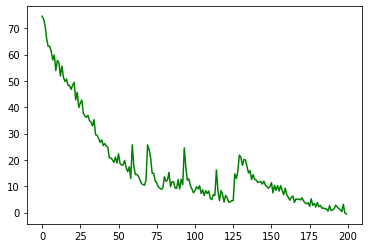

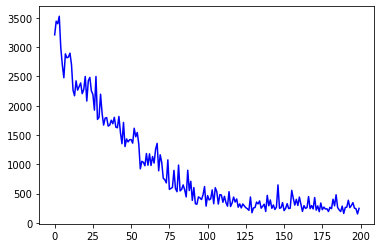

In [70]:
c.fit(200,30)

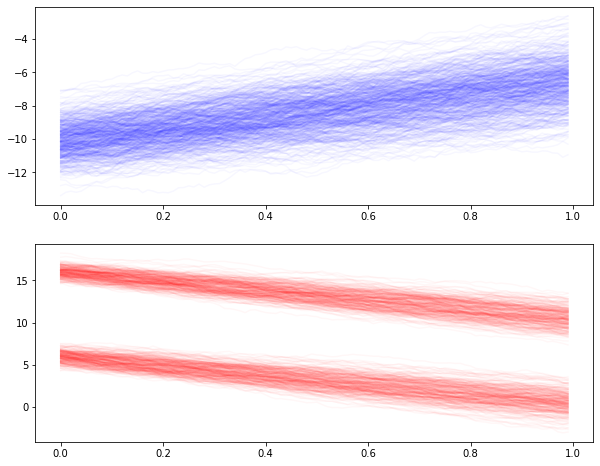

In [71]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
for x1 in X1:
    t, Xt = c.sample_trajectory(x1.reshape(1,-1),c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver)
    axs[0].plot(t.flatten(), Xt.flatten(), 'b', alpha=0.03, )
BXt = []   

for x2 in X2:
    t_, Xt_ = c.sample_trajectory(x2.reshape(1,-1),c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver)
    BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xt_.flatten(), 'r', alpha=0.03)


In [60]:
# # @partial(jit, static_argnums=(0,2))
# npr.seed(0)
# def transport_batch(self, batch_x, forwards):
#     theta = self.theta_f if forwards else self.theta_b    
#     b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

#     def inner_loss_loop_23(x_):
#         t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=number_time_steps, theta=theta)
#         return Xt[:,-1,:]

#     return inner_loss_loop_23(batch_x)

In [61]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [62]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

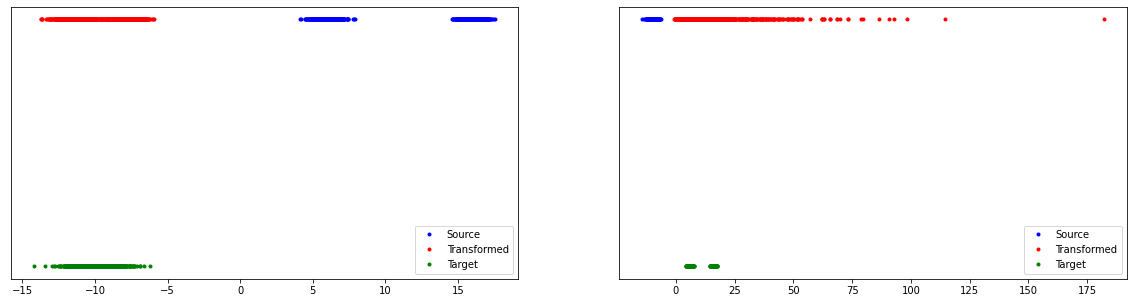

In [63]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

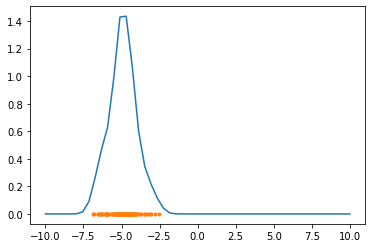

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

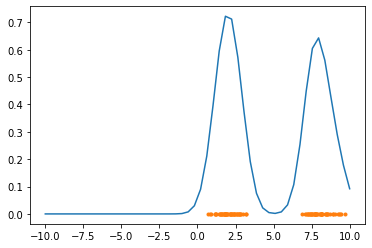

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")